Source: [Joel Grus - Learning Data Science Using Functional Python](https://www.youtube.com/watch?v=ThS4juptJjQ)

[https://github.com/joelgrus/stupid-itertools-tricks-pydata](https://github.com/joelgrus/stupid-itertools-tricks-pydata)

In [1]:
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import random
from functools import reduce, partial
from operator import add

In [2]:
from itertools import count, repeat, cycle, islice, tee, repeat, accumulate, chain

head = next

def tail(it):
  next(it)
  return it

def take(n, it):
  return [x for x in islice(it, n)]

def drop(n, it):
  return islice(it, n, None)

def iterate(f, x):
  """return (x, f(x), f(f(x)), ...)"""
  return accumulate(repeat(x), lambda fx, _: f(fx))

def until_convergence(it):
  """returns elements of it until the same element appears twice in a row,
  then stops"""
  def no_repeat(prev, curr):
    if prev == curr: raise StopIteration
    else: return curr

  return accumulate(it, no_repeat)

def within_tolerance(tol, prev, curr):
  if abs(prev - curr) < tol:
    raise StopIteration
  else:
    return curr

def until_nearly_convergence(it, tolerance=0.001):
  return accumulate(it, partial(within_tolerance, tolerance))

In [4]:
def k_meanses(points, k):
  initial_means = random.sample(points, k)
  return iterate(partial(new_means, points),
                 initial_means)

def no_repeat(prev, curr):
  if prev == curr: raise StopIteration
  else: return curr

def until_convergence(it):
  return accumulate(it, no_repeat)

def new_means(points, old_means):
  k = len(old_means)
  assignments = [closest_index(point, old_means)
                 for point in points]
  clusters = [[point
               for point, c in zip(points, assignments)
               if c == j] for j in range(k)]
  return [cluster_mean(cluster) for cluster in clusters]

def closest_index(point, means):
  return min(enumerate(means),
             key=lambda pair: squared_distance(point, pair[1]))[0]

def squared_distance(p, q):
  return sum((p_i - q_i)**2 for p_i, q_i in zip(p, q))

def cluster_mean(points):
  num_points = len(points)
  dim = len(points[0]) if points else 0
  sum_points = [sum(point[j] for point in points)
                for j in range(dim)]
  return [s / num_points for s in sum_points]


def run_kmeans_functional(seed=0):
  random.seed(seed)
  data = [(random.random(), random.random()) for _ in range(500)]
  meanses = [mean for mean in until_convergence(k_meanses(data, 5))]

  x, y = zip(*data)
  plt.scatter(x, y, color='black')

  colors = ['r', 'g', 'b', 'c', 'm']
  for i, means in enumerate(meanses):
    for m, color in zip(means, colors):
      plt.plot(*m, color=color,
               marker='*',
               markersize=3*i)

  plt.show()


def run_kmeans_animation(seed=0, k=5):
  random.seed(seed)
  data = [(random.random(), random.random()) for _ in range(500)]
  meanses = [mean for mean in until_convergence(k_meanses(data, k))]

  # colors = random.sample(list(matplotlib.colors.cnames), k)
  colors = ['r', 'g', 'b', 'c', 'm']

  def animation_frame(nframe):
    means = meanses[nframe]
    plt.cla()
    assignments = [closest_index(point, means)
                   for point in data]
    clusters = [[point
                 for point, c in zip(data, assignments)
                 if c == j] for j in range(k)]

    for cluster, color, mean in zip(clusters, colors, means):
      x, y = zip(*cluster)
      plt.scatter(x, y, color=color)
      plt.plot(*mean, color=color, marker='*', markersize=20)

  fig = plt.figure(figsize=(5,4))
  anim = animation.FuncAnimation(fig, animation_frame, frames=len(meanses))
  anim.save('kmeans_cluster.gif', writer='imagemagick', fps=4)

def run_kmeans_animation2(seed=0, k=5):
  random.seed(seed)
  data = [(random.choice([0,1,2,4,5]) + random.random(),
           random.normalvariate(0, 1)) for _ in range(500)]
  meanses = [mean for mean in until_convergence(k_meanses(data, k))]

  # colors = random.sample(list(matplotlib.colors.cnames), k)
  colors = ['r', 'g', 'b', 'c', 'm']

  def animation_frame(nframe):
    means = meanses[nframe]
    plt.cla()
    assignments = [closest_index(point, means)
                   for point in data]
    clusters = [[point
                 for point, c in zip(data, assignments)
                 if c == j] for j in range(k)]

    for cluster, color, mean in zip(clusters, colors, means):
      x, y = zip(*cluster)
      plt.scatter(x, y, color=color)
      plt.plot(*mean, color=color, marker='*', markersize=20)

  fig = plt.figure(figsize=(5,4))
  anim = animation.FuncAnimation(fig, animation_frame, frames=len(meanses))
  anim.save('kmeans_animation.gif', writer='imagemagick', fps=4)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


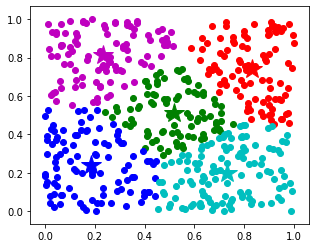

In [5]:
run_kmeans_animation()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


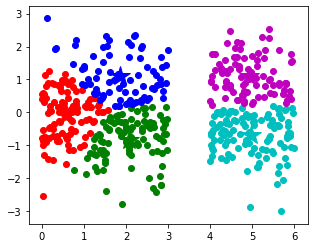

In [6]:
run_kmeans_animation2()

In [10]:
from itertools import chain
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import math
from functools import reduce, partial
from operator import add

def gradient_step(df, alpha, x_i):
  return [x_ij + alpha * df_j
          for x_ij, df_j in zip(x_i, df(x_i))]

def gradient_descent(df, x_0, alpha=0.1):
  return iterate(partial(gradient_step, df, -alpha), x_0)

def run_gradient_descent(seed=0):
  """runs gradient descent to find a minimum of x^2 + y^2"""
  random.seed(seed)
  colors = [color for color in matplotlib.colors.cnames]

  def random_point():
    return (2 * random.random() - 1, 2 * random.random() - 1)

  def df(x_i):
    """this is the gradient of x^2 + y^2"""
    return [2 * x_ij for x_ij in x_i]

  for color in random.sample(colors, 50):
    path = take(10, gradient_descent(df, random_point()))
    for i, (x, y) in enumerate(path):
      plt.plot(x, y, color=color, marker='*', markersize=20-2*i)

  plt.show()

def run_gradient_descent_animation(seed=0, nframes=25):
  random.seed(seed)

  colors = [color for color in matplotlib.colors.cnames]

  def random_point():
    return (2 * random.random() - 1, 2 * random.random() - 1)

  def df(x_i):
    """this is the gradient of x^2 + y^2"""
    return [2 * x_ij for x_ij in x_i]

  paths = [take(nframes, gradient_descent(df, random_point()))
           for _ in range(50)]

  def animation_frame(nframe):
    points = [path[nframe] for path in paths]

    for color, point in zip(colors, points):
      markersize = 10 - 10 * nframe / nframes
      plt.plot(*point, color=color, marker='*', markersize=markersize)

  fig = plt.figure(figsize=(5,4))
  anim = animation.FuncAnimation(fig, animation_frame, frames=nframes)
  anim.save('gradient_descent.gif', writer='imagemagick', fps=4)


def run_gradient_descent2(seed=0):
  """runs gradient descent to find a minimum of
  exp(x^3 / 3 + x - y^2)"""

  colors = [color for color in matplotlib.colors.cnames]

  def random_point():
    return (3 * random.random() - 1, 3 * random.random() - 1)

  def f(x):
    """has min at (1,0), saddle point at (-1,0)"""
    return -math.exp(x[0]**3/-3 + x[0] - x[1]**2)

  def df(x):
    return ((1 - x[0]**2) * f(x), -2 * x[1] * f(x))

  for color in random.sample(colors, 50):
    path = take(100, gradient_descent(df, random_point()))
    for i, (x, y) in enumerate(path):
      plt.plot(x, y, color=color, marker='*', markersize=25-i/4)

  plt.show()

def run_gradient_descent_animation2(seed=0, nframes=25):
  random.seed(seed)

  colors = [color for color in matplotlib.colors.cnames]

  def random_point():
    return (2 * random.random() - 1, 2 * random.random() - 1)

  def f(x):
    """has min at (1,0), saddle point at (-1,0)"""
    return -math.exp(x[0]**3/-3 + x[0] - x[1]**2)

  def df(x):
    return ((1 - x[0]**2) * f(x), -2 * x[1] * f(x))

  paths = [take(nframes, gradient_descent(df, random_point()))
           for _ in range(50)]

  def animation_frame(nframe):
    points = [path[nframe] for path in paths]

    for color, point in zip(colors, points):
      markersize = 10 - 10 * nframe / nframes
      plt.plot(*point, color=color, marker='*', markersize=markersize)

  fig = plt.figure(figsize=(5,4))
  anim = animation.FuncAnimation(fig, animation_frame, frames=nframes)
  anim.save('gradient_descent2.gif', writer='imagemagick', fps=4)

def sgd_step(df, alpha, prev_beta, xy_i):
  """df is a function of x_i, y_i, beta"""
  x_i, y_i = xy_i
  gradient = df(x_i, y_i, prev_beta)
  return [beta_j + alpha * df_j
          for beta_j, df_j in zip(prev_beta, gradient)]

def sgd(df, x, y, beta_0, alpha=0.1):
  xys = chain([beta_0], cycle(zip(x, y)))
  return accumulate(xys, partial(sgd_step, df, -alpha))

def run_sgd(seed=0, steps=5000, show_every=500):
  random.seed(seed)
  x = [(1, random.random()) for _ in range(100)]
  y = [-5 * x_i[0] + 10 * x_i[1] + random.random() for x_i in x]

  def predict(x_i, beta): return x_i[0] * beta[0] + x_i[1] * beta[1]

  def error(x_i, y_i, beta): return predict(x_i, beta) - y_i

  def sqerror(x_i, y_i, beta): return error(x_i, y_i, beta) ** 2

  def sqerror_gradient(x_i, y_i, beta):
    return (2 * x_i[0] * error(x_i, y_i, beta),
            2 * x_i[1] * error(x_i, y_i, beta))

  beta_0 = (random.random(), random.random())
  results = [x for x in take(steps, sgd(sqerror_gradient, x, y, beta_0, 0.01))]

  subresults = results[::show_every]

  _, xs = zip(*x)
  plt.scatter(xs, y)

  for i, (a, b) in enumerate(subresults):
    plt.plot([0, 1], [a, a+b])

  plt.show()
  return subresults

def run_sgd_animation(seed=0, steps=5000, show_every=250):
  random.seed(seed)
  x = [(1, random.random()) for _ in range(100)]
  y = [-5 * x_i[0] + 10 * x_i[1] + random.random() for x_i in x]

  def predict(x_i, beta): return x_i[0] * beta[0] + x_i[1] * beta[1]

  def error(x_i, y_i, beta): return predict(x_i, beta) - y_i

  def sqerror(x_i, y_i, beta): return error(x_i, y_i, beta) ** 2

  def sqerror_gradient(x_i, y_i, beta):
    return (-2 * x_i[0] * error(x_i, y_i, beta),
            -2 * x_i[1] * error(x_i, y_i, beta))

  beta_0 = (random.random(), random.random())
  results = [x for x in take(steps, sgd(sqerror_gradient, x, y, beta_0, 0.01))]

  subresults = results[::show_every]
  nframes = len(subresults)

  def animation_frame(nframe):
    a, b = subresults[nframe]
    plt.plot([0, 1], [a, a+b])

  fig = plt.figure(figsize=(5,4))
  _, xs = zip(*x)
  fig.gca().scatter(xs, y)

  anim = animation.FuncAnimation(fig, animation_frame, frames=nframes)
  anim.save('sgd.gif', writer='imagemagick', fps=4)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


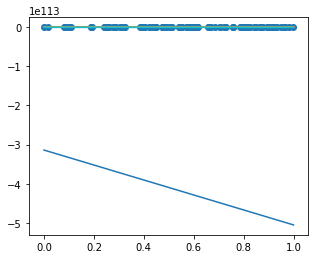

In [11]:
run_sgd_animation(seed=0, steps=10000, show_every=250)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


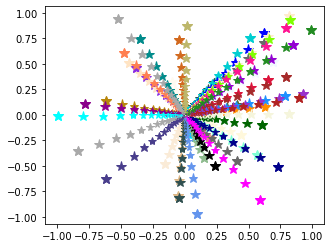

In [13]:
run_gradient_descent_animation()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


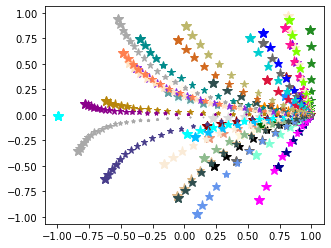

In [12]:
run_gradient_descent_animation2()